In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time
from pathlib                        import Path
from PIL                            import Image

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt 
import gc
import glob
from skimage                        import img_as_ubyte
from skimage                        import io
import shutil

2025-05-07 11:15:18.209796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746630918.286934    5601 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746630918.310199    5601 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746630918.469114    5601 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746630918.469130    5601 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746630918.469131    5601 computation_placer.cc:177] computation placer alr

In [2]:
general_directory ='/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5'
#general_directory = '/home/guiomar/Desktop/CODES/DLCODES-VER-5'
#general_directory ='/home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI'

subdirectories = ['/Geometry','/Magnitude','/Pression','/U001','/U002']
geo_path = general_directory + subdirectories[0]
v_path =  general_directory + subdirectories[1]
p_path =  general_directory + subdirectories[2]
vx_path = general_directory + subdirectories[3]
vy_path = general_directory + subdirectories[4]

In [3]:
# split dataset 
n_train = 0.7
n_valid = 0.2
n_test =  0.1
w,h=256,128

In [4]:
#method for reading image    
def get_img(img_name):
    return ski.io.imread(img_name)

# method for turning to a grey or binary image 
def processing(image,option=True):
        x = get_img(image)  
        x = rgb2gray(x)       # It returns a grayscale image with floating point values in the range from 0 to 1
        x =cv.resize(x,(w,h)) # Reshape image 
    
        # Binary option otherwise gray
        if (option):
            x=ski.util.img_as_ubyte(x)  # Convert it back to the original data type and the data range back 0 to 255. 
                                        # It is often better to use image values represented by floating point values 
            best_value_threshold=np.round(filters.threshold_otsu(x)) #  Otsu’s method calculates an “optimal” threshold

            _,x= cv.threshold(x, best_value_threshold, 255, cv.THRESH_BINARY)
            x=x/255.
        x=x[:, :, np.newaxis]
        return x

In [5]:
# method for creating npy of each image
def npy_create (path,name,option=True):
    images= sorted([os.path.join(path,fname) for fname in os.listdir(path) if fname.endswith(".png")])
    name_file = name
    new_file= general_directory + '/' + name_file
    os.makedirs(new_file, exist_ok=True)
    for img in images[1:]:
        name_img = os.path.basename(img)
        path=new_file+'/'+ name_img
        x=processing(img,option)
        np.save(path,x)  

In [6]:
# Mask each image
def mask (name_file,name_data,path_file_1,path_file_2=None):
    print('enter')
    if path_file_2 == None:
        path_1 = Path(path_file_1)
        file_npy_1=sorted(list(path_1.glob('*.npy')))
        current_directory = Path.cwd()
        save_in = str(current_directory) + '/' + name_file 
        os.makedirs(save_in, exist_ok=True)
        n = 1
        for f1 in file_npy_1:
            array_1 = np.load(f1)
            save= save_in+ '/'+name_data+f'_{n:05d}.png'
            array_2d = img_as_ubyte(array_1.squeeze())
            io.imsave(save, array_2d)
            n=n+1
    else:
        path_1 = Path(path_file_1)
        path_2 = Path(path_file_2)
        file_npy_1=sorted(list(path_1.glob('*.npy')))
        file_npy_2=sorted(list(path_2.glob('*.npy')))
        current_directory = Path.cwd()
        save_in = str(current_directory) + '/' + name_file 
        os.makedirs(save_in, exist_ok=True)
        n = 1 
        for f1, f2 in zip(file_npy_1,file_npy_2):
            array_1 = np.load(f1)
            array_2 = np.load(f2)
            array_masked=array_1*array_2
            save= save_in+ '/'+name_data+f'_{n:05d}.png'
            array_2d = img_as_ubyte(array_masked.squeeze())
            io.imsave(save, array_2d)
            n=n+1

In [7]:
def split_data(file,n_train=n_train,n_valid=n_valid,n_test=n_test):
     n_sample=len(file)
     if (round(n_train + n_valid + n_test,2) == 1.0):
        n_train= math.floor(n_sample*n_train)
        n_valid = math.floor(n_sample*n_valid) + n_train
        n_test = math.floor(n_sample*n_test) + n_valid
        (train,valid,test) = (file[0:n_train], file[n_train:n_valid],file[n_valid:n_test]) 
     return train,valid,test
    
# separating images into different folders
def create_files(name_file): 
    
   # name_file = geo_masked mag_masked  vx_masked vy_masked p_masked
   # path = /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/mag_masked
    
    path=general_directory + name_file
    file = Path(path)
    
    images= sorted(file.glob('*.png')) 
    train,valid,test =  split_data(images)
    
    path_train = general_directory +name_file+ '/train'
    path_test = general_directory + name_file+'/test'
    path_valid = general_directory +name_file+ '/valid'
    print('creating')
    os.makedirs(path_train, exist_ok=True)
    os.makedirs(path_test, exist_ok=True)
    os.makedirs(path_valid, exist_ok=True)
    
    for img in train:
        p =  path_train + '/' + img.name
        shutil.move(img,p)
    
    for img in valid:  
        p = path_valid + '/' + img.name
        shutil.move(img,p)

    for img in test: 
        p = path_test + '/' + img.name
        shutil.move(img,p)
    

### Execution

In [ ]:
# ***** 1 *******
npy_create (geo_path,'geo_npy')
npy_create (v_path,'v_npy',False)
npy_create (p_path,'p_npy',False)
npy_create (vx_path,'vx_npy',False)
npy_create (vy_path,'vy_npy',False)


In [ ]:
# ******** 2 *************
path_file_1 = general_directory + '/geo_npy'
path_file_2 = general_directory +'/v_npy'
path_file_3 = general_directory +'/vx_npy'
path_file_4 = general_directory +'/vy_npy'
path_file_5 = general_directory +'/p_npy'


#path_file_1='/home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/geo_npy'
#path_file_2='/home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/v_npy'
#path_file_3='/home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/vx_npy'
#path_file_4='/home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/vy_npy'
#path_file_5='/home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/p_npy'

mask('geo_masked','g',path_file_1)
mask('mag_masked','v',path_file_1,path_file_2)
mask('vx_masked','vx',path_file_1,path_file_3)
mask('vy_masked','vy',path_file_1,path_file_4)
mask('p_masked','p',path_file_1,path_file_5)

In [ ]:
# ******** 3 ************
create_files('/geo_masked')
create_files('/mag_masked')
create_files('/vx_masked')
create_files('/vy_masked')
create_files('/p_masked')

### Working with ImageDataGenerator

In [8]:
def dataset(directory,batch_size=32):
    data = keras.utils.image_dataset_from_directory(directory,
    labels=None,
    label_mode=None,
    image_size=(128, 256),
    color_mode="grayscale",
    shuffle=False,
    batch_size=batch_size)
    return data

In [9]:
path_1= general_directory + '/geo_masked' + '/train'
path_2= general_directory + '/geo_masked' + '/test'
path_3= general_directory + '/geo_masked' + '/valid'

path_4= general_directory + '/mag_masked' + '/train'
path_5= general_directory + '/mag_masked' + '/test'
path_6= general_directory + '/mag_masked' + '/valid'

path_7= general_directory + '/vx_masked' + '/train'
path_8= general_directory + '/vx_masked' + '/test'
path_9= general_directory + '/vx_masked' + '/valid'

path_10= general_directory + '/vy_masked' + '/train'
path_11= general_directory + '/vy_masked' + '/test'
path_12= general_directory + '/vy_masked' + '/valid'

path_13= general_directory + '/p_masked' + '/train'
path_14= general_directory + '/p_masked' + '/test'
path_15= general_directory + '/p_masked' + '/valid'



In [10]:
g_train = dataset(path_1)
g_test  = dataset(path_2)
g_valid = dataset(path_3)

v_train = dataset(path_4)
v_test  = dataset(path_5)
v_valid = dataset(path_6)

vx_train = dataset(path_7)
vx_test  = dataset(path_8)
vx_valid = dataset(path_9)

vy_train = dataset(path_10)
vy_test  = dataset(path_11)
vy_valid = dataset(path_12)

p_train = dataset(path_13)
p_test = dataset(path_14)
p_valid  = dataset(path_15)

Found 14000 files.
Found 2000 files.
Found 4000 files.


I0000 00:00:1746630970.863252    5601 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2234 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 14000 files.
Found 2000 files.
Found 4000 files.
Found 14000 files.
Found 2000 files.
Found 4000 files.
Found 14000 files.
Found 2000 files.
Found 4000 files.
Found 14000 files.
Found 2000 files.
Found 4000 files.


In [11]:
# combination of output datasets
output_train = tf.data.Dataset.zip((v_train,vx_train,vy_train,p_train))
output_test = tf.data.Dataset.zip((v_test,vx_test,vy_test,p_test))
output_valid = tf.data.Dataset.zip((v_valid,vx_valid,vy_valid,p_valid))

# combination of input datasets with output datasets
final_train = tf.data.Dataset.zip((g_train,output_train))
final_test = tf.data.Dataset.zip((g_test,output_test))
final_valid = tf.data.Dataset.zip((g_valid,output_valid))

### Model Definition

In [38]:
img_inputs = keras.Input(shape=(h, w, 1)) 

# Layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)


output1 = Conv2D(1,(1,1),name='output_magnitude')(x)
output2 = Conv2D(1,(1,1),name='output_u001')(x)
output3 = Conv2D(1,(1,1),name='output_u002')(x)
output4 = Conv2D(1,(1,1),name='output_pression')(x)

model = keras.Model(inputs=img_inputs, outputs=[output1, output2, output3, output4])

model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │     18,496 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_magnitude    │ (None, 128, 256,  │         65 │ conv2d_3[0][0]    │
│ (Conv2D)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_u001         │ (None, 128, 256,  │         65 │ conv2d_3[0][0]    │
│ (Conv2D)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_u002         │ (None, 128, 256,  │         65 │ conv2d_3[0][0]    │
│ (Conv2D)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_pression     │ (None, 128, 256,  │         65 │ conv2d_3[0][0]    │
│ (Conv2D)            │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,076 (74.52 KB)

 Trainable params: 19,076 (74.52 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(loss=['mse', 'mse', 'mse', 'mse'], optimizer='RMSprop', metrics=["mae","mae","mae","mae"])

print("Starting trainig")

history = model.fit(final_train,epochs=3,validation_data = final_valid)
   
model.compile(optimizer='RMSprop', 
              loss = {  'output_magnitude': 'mean_squared_error' ,
                        'output_u001': 'mean_squared_error' , 
                        'output_u002': 'mean_squared_error',
                        'output_pression': 'mean_squared_error'},
              
              metrics={ 'output_magnitude': ['mae'],
                        'output_u001': ['mae'],
                        'output_u002': ['mae'],
                        'output_pression': ['mae'] })

Starting trainig
Epoch 1/3


2025-05-07 11:47:56.178226: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.24 = (f32[32,32,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,256]{3,2,1,0} %bitcast.2199, f32[32,1,3,3]{3,2,1,0} %bitcast.2206, f32[32]{0} %bitcast.2747), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_2_1/convolution" source_file="/home/ppgi/miniconda3/envs/newEnviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-07 11:47:56.182117: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pic

437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 2726.8831 - output_magnitude_loss: 612.3438 - output_magnitude_mae: 18.1423 - output_pression_loss: 1297.5721 - output_pression_mae: 26.9076 - output_u001_loss: 535.5756 - output_u001_mae: 17.7943 - output_u002_loss: 281.3911 - output_u002_mae: 11.1715

2025-05-07 11:48:52.072844: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.24 = (f32[16,32,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,128,256]{3,2,1,0} %bitcast.2199, f32[32,1,3,3]{3,2,1,0} %bitcast.2206, f32[32]{0} %bitcast.2747), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_2_1/convolution" source_file="/home/ppgi/miniconda3/envs/newEnviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-07 11:48:52.076300: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pic

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 2725.8989 - output_magnitude_loss: 612.0070 - output_magnitude_mae: 18.1385 - output_pression_loss: 1297.3094 - output_pression_mae: 26.9048 - output_u001_loss: 535.3784 - output_u001_mae: 17.7912 - output_u002_loss: 281.2033 - output_u002_mae: 11.1682

2025-05-07 11:48:56.480832: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[32,32,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,256]{3,2,1,0} %bitcast.792, f32[32,1,3,3]{3,2,1,0} %bitcast.799, f32[32]{0} %bitcast.801), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_2_1/convolution" source_file="/home/ppgi/miniconda3/envs/newEnviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-07 11:48:56.484095: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

438/438 ━━━━━━━━━━━━━━━━━━━━ 67s 133ms/step - loss: 2724.9192 - output_magnitude_loss: 611.6717 - output_magnitude_mae: 18.1348 - output_pression_loss: 1297.0481 - output_pression_mae: 26.9020 - output_u001_loss: 535.1821 - output_u001_mae: 17.7881 - output_u002_loss: 281.0164 - output_u002_mae: 11.1649 - val_loss: 2162.3511 - val_output_magnitude_loss: 418.5285 - val_output_magnitude_mae: 15.6233 - val_output_pression_loss: 1163.0431 - val_output_pression_mae: 26.1488 - val_output_u001_loss: 413.3249 - val_output_u001_mae: 15.4970 - val_output_u002_loss: 167.4544 - val_output_u002_mae: 9.0064
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 2171.9771 - output_magnitude_loss: 426.7988 - output_magnitude_mae: 15.9070 - output_pression_loss: 1174.5393 - output_pression_mae: 25.7375 - output_u001_loss: 412.9622 - output_u001_mae: 15.7499 - output_u002_loss: 157.6777 - output_u002_mae: 7.9704 - val_loss: 2154.2007 - val_output_magnitude_loss: 427.7135 - val_output_magnitude_ma

In [40]:

# model.load_weights('ruta/pesos.h5')

results = model.evaluate(final_test) 


print("Resultados de la evaluación:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2285.7231 - output_magnitude_loss: 433.5195 - output_magnitude_mae: 16.2942 - output_pression_loss: 1234.8997 - output_pression_mae: 24.9429 - output_u001_loss: 427.9966 - output_u001_mae: 16.4023 - output_u002_loss: 189.3072 - output_u002_mae: 10.0949

2025-05-07 11:50:52.279480: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[16,32,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,128,256]{3,2,1,0} %bitcast.792, f32[32,1,3,3]{3,2,1,0} %bitcast.799, f32[32]{0} %bitcast.801), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_2_1/convolution" source_file="/home/ppgi/miniconda3/envs/newEnviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-07 11:50:52.282542: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2282.9944 - output_magnitude_loss: 433.3197 - output_magnitude_mae: 16.2925 - output_pression_loss: 1232.5487 - output_pression_mae: 24.9231 - output_u001_loss: 427.8138 - output_u001_mae: 16.4008 - output_u002_loss: 189.1857 - output_u002_mae: 10.0933
Resultados de la evaluación:
loss: 2226.1392
compile_metrics: 429.1042
output_magnitude_loss: 423.9555
output_u001_loss: 186.6298
output_u002_loss: 1182.4032
output_pression_loss: 16.2558


### Predicctions

In [54]:
y_pred = model.predict(final_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


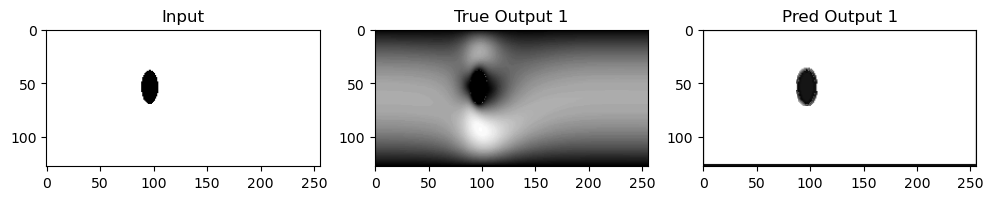

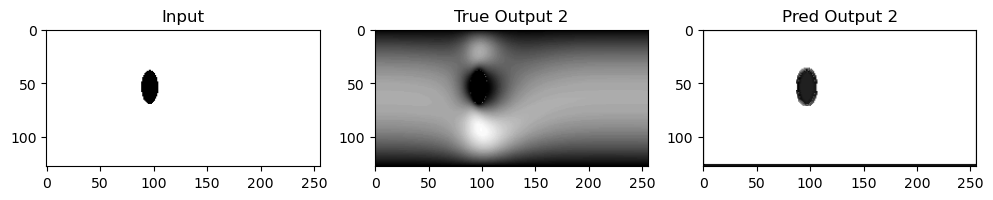

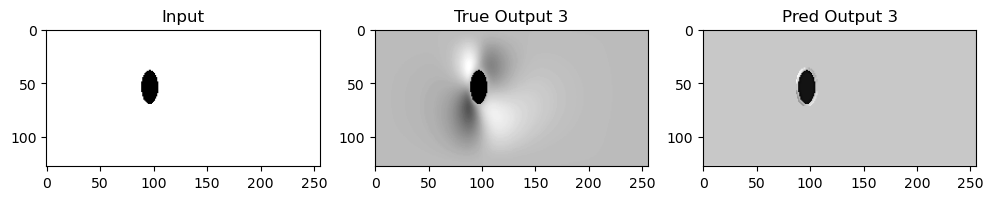

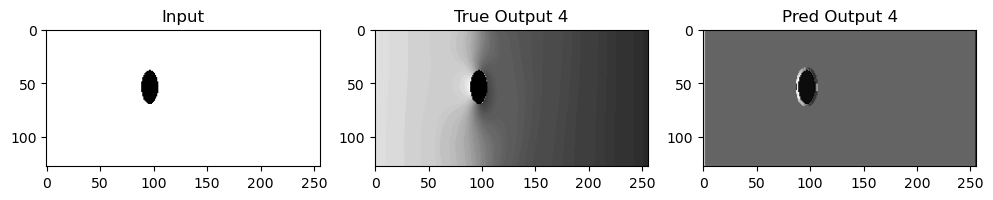

In [74]:
for x_test,y_true in final_test.take(1):
    y_pred = model.predict(x_test)
    for i in range(4):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_test[0],cmap='gray')
        axs[0].set_title("Input")

        axs[1].imshow(y_true[i][0],cmap='gray')
        axs[1].set_title(f"True Output {i+1}")

        axs[2].imshow(y_pred[i][0],cmap='gray')
        axs[2].set_title(f"Pred Output {i+1}")
        plt.show()
        

    

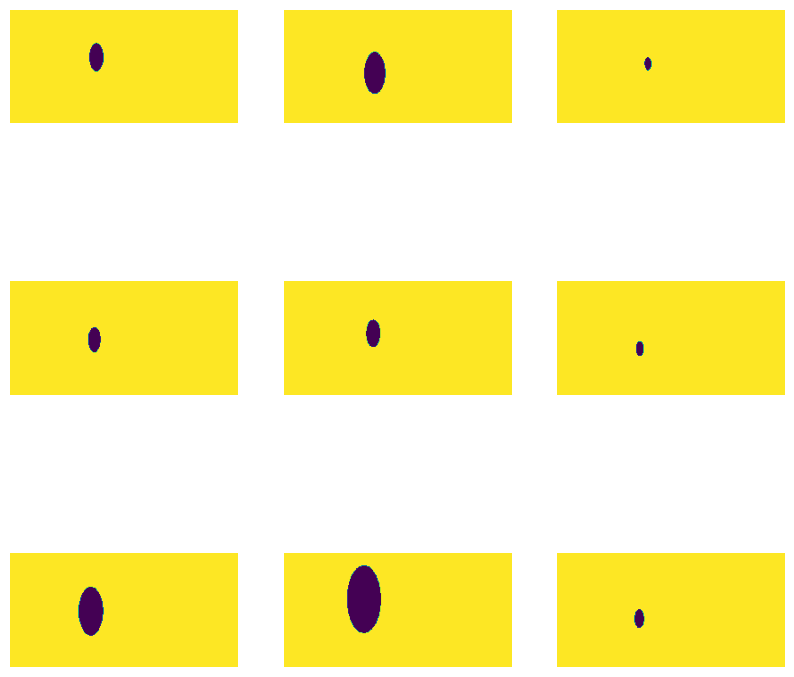

In [20]:

plt.figure(figsize=(10, 10))
for xbatches, ybatches in final_test.take(1):
  for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(images[i])
    plt.axis("off")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

idx = 0  # índice dentro del batch (0 a batch_size-1)

input_img = x_batch[idx].numpy()
true_imgs = [y[idx].numpy() for y in y_batch]
pred_imgs = [y[idx] for y in y_pred]

fig, axs = plt.subplots(5, 3, figsize=(12, 15))

# Fila 0: entrada
axs[0, 1].imshow(input_img)
axs[0, 1].set_title("Input Image")
axs[0, 0].axis("off")
axs[0, 2].axis("off")

# Filas 1-4: outputs
for i in range(4):
    axs[i+1, 0].imshow(true_imgs[i])
    axs[i+1, 0].set_title(f"True Output {i+1}")
    
    axs[i+1, 1].imshow(pred_imgs[i])
    axs[i+1, 1].set_title(f"Predicted Output {i+1}")
    
    # Mapa de error absoluto (en escala de grises)
    abs_error = np.abs(true_imgs[i] - pred_imgs[i])
    error_map = np.mean(abs_error, axis=-1)  # promedio sobre canales
    axs[i+1, 2].imshow(error_map, cmap='hot')
    axs[i+1, 2].set_title(f"Error Map {i+1}")

# Limpieza
for ax in axs.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()
